# Building an ARIMA model for time series forecasting of river flow data


In [1]:
# import data and view as plot
from arima_functions import *
import pandas as pd
import matplotlib.pyplot as plt

# import data - using data from the Brahamaputra River, Bangladesh
file_path = "DATA/2651100_Q_Day.Cmd.txt"
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)

print("Station Information:")
print(station_info)
print("Data:")
print(parsed_data.head())


Station Information:
{'GRDC-No.': '2651100', 'River': 'BRAHMAPUTRA RIVER', 'Station': 'BAHADURABAD', 'Country': 'BD', 'Latitude (DD)': '25.18', 'Longitude (DD)': '89.67', 'Catchment area (km²)': None, 'Altitude (m ASL)': '19.0', 'Time series': '1985-04 - 1992-03', 'No. of years': '8', 'Last update': '2018-05-29'}
Data:
         Date   Value
0  1985-04-03  6370.0
1  1985-04-04  6320.0
2  1985-04-05  6290.0
3  1985-04-06  6350.0
4  1985-04-07  6920.0


<Figure size 1000x600 with 0 Axes>

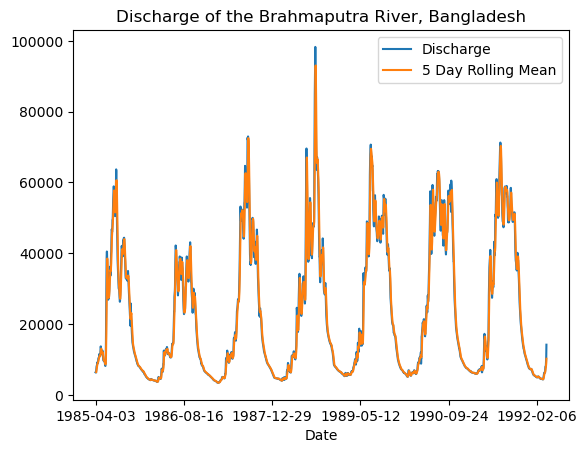

In [2]:
# plot the data
plt.figure(figsize=(10,6))
parsed_data.plot(y='Value', x='Date', title='Discharge of the Brahmaputra River, Bangladesh')
# add rolling mean value    
parsed_data['Value'].rolling(window=5).mean().plot()
parsed_data['Avg'] = parsed_data['Value'].rolling(window=5).mean()
plt.legend(['Discharge', '5 Day Rolling Mean'])
plt.show()

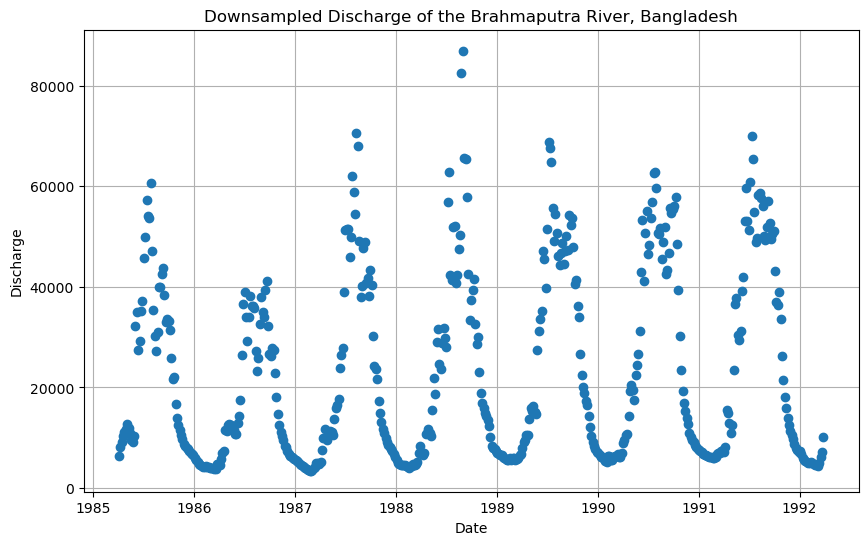

In [3]:
# downsample to 5 day intervals
parsed_data = downsample(parsed_data)

# Plot the downsampled data
plt.figure(figsize=(10, 6))
plt.plot(parsed_data['Sampled'], marker='o', linestyle='-')
plt.title('Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


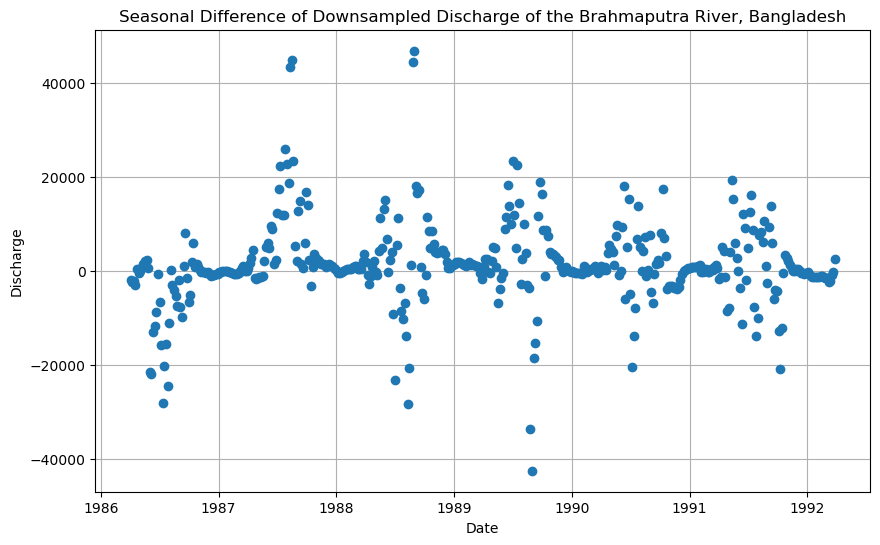

In [4]:
# as data will be seasonal, do seasonal differencing
parsed_data['Seasonal Difference'] = (parsed_data['Sampled'] - parsed_data['Sampled'].shift(365))
plt.figure(figsize=(10, 6))
plt.plot(parsed_data['Seasonal Difference'], marker='o', linestyle='-')
plt.title('Seasonal Difference of Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


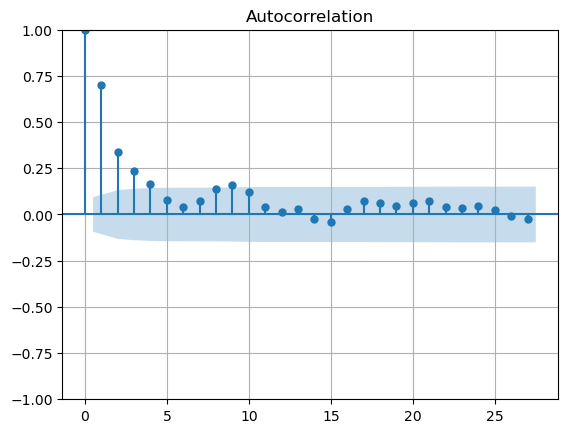

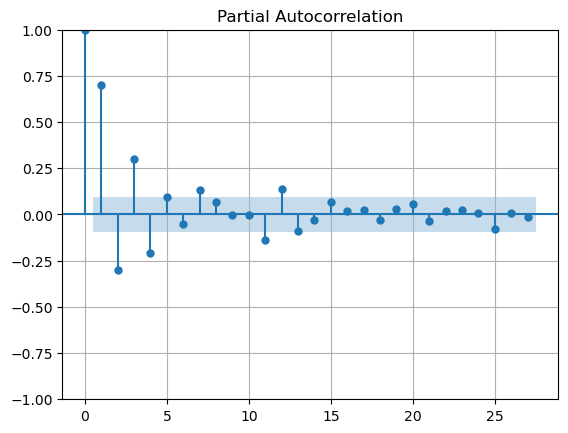

In [5]:
# calculate the ACF and PACF to determine order of ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)
plot_pacf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)


Roughly reading from these plots:
- Predict around 1-2 auto-regressive terms
- 0 non-seasonal differences
- 2 lagged forecast errors

and for the seasonal component:
- 0 auto-regressive terms
- 1 seasonal difference
- 0 lagged forecast errors
with a seasonal period of 73 (365/5 due to down-sampling)

In [6]:
# split the data into training and testing sets
train, test = split_data(parsed_data, split=0.8)

# fit the ARIMA model
model = arima_model(train, order=(2,0,2), seasonal_order=(0,1,0,73))

/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)


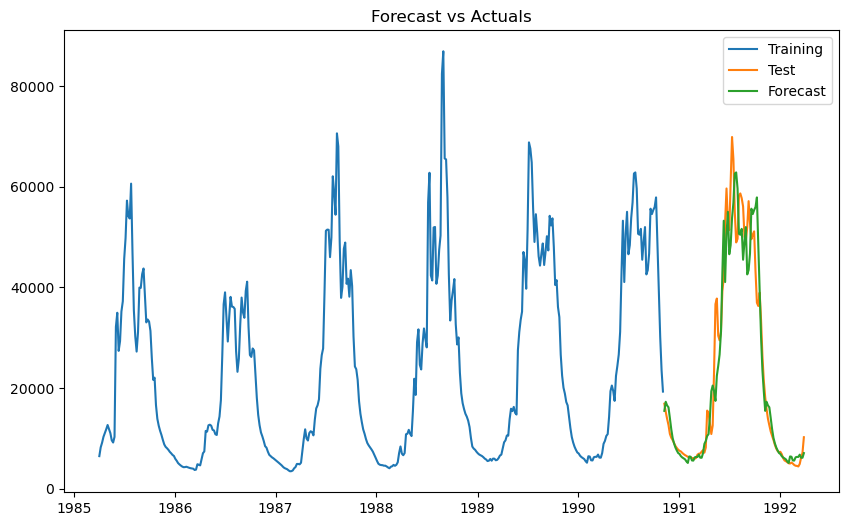

In [7]:
# predict the future using the model and plot the results
forecast_data = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()



In [8]:
# # find best model - switch to python to run this cell   
# import itertools

# # Define parameters for ARIMA orders
# p = range(0,5)  # AutoRegressive (AR) order
# d = [0]  # Integrated (I) order data is already stationary and downsampled
# q = range(0, 3)  # Moving Average (MA) order

# # Define seasonal parameters for ARIMA seasonal orders
# P = [0]  # Seasonal AutoRegressive (SAR) order
# D = range(0,2)  # Seasonal Integrated (SI) order 
# Q = [0]  # Seasonal Moving Average (SMA) order
# s = [73]  # Seasonal period 

# # Generate all possible combinations of parameters
# orders = list(itertools.product(p, d, q))
# seasonal_orders = list(itertools.product(P, D, Q, s))

# best_aic = float('inf')
# best_model = None

# # Iterate over all combinations of parameters and fit the models
# for order in orders:
#     for seasonal_order in seasonal_orders:
#         try:
#             model = ARIMA(train.dropna(), order=order, seasonal_order=seasonal_order)
#             model_fit = model.fit()

#             # Check if the current model has a lower AIC value than the best model found so far
#             if model_fit.aic < best_aic:
#                 best_aic = model_fit.aic
#                 best_model = model_fit
#                 best_order = order
#                 best_seasonal_order = seasonal_order

#         except:
#             continue

# # Print the summary of the best model
# print("Best Model:")
# print(best_model.summary())
# print("Best AIC:", best_aic)
# print("Best ARIMA Order:", best_order)
# print("Best Seasonal Order:", best_seasonal_order)

# # store the model
# # best_model.save('bramaputra_best_model.pkl')

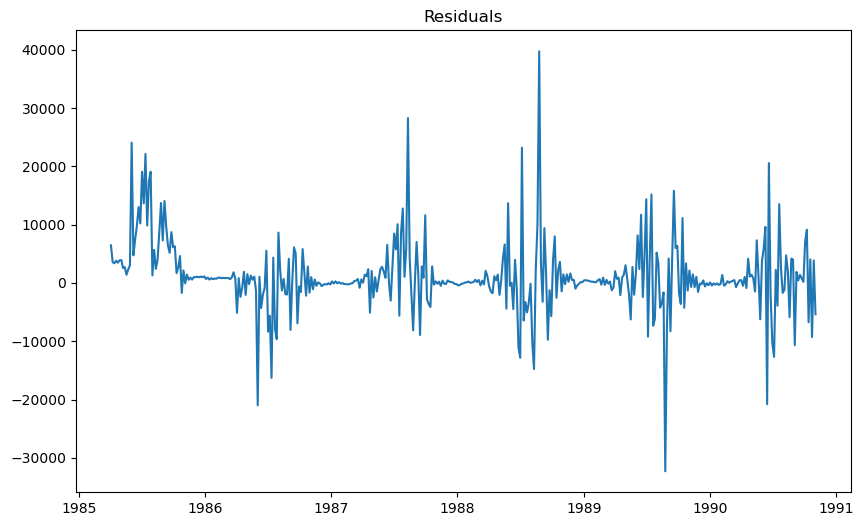

Mean Squared Error: 35769479.21307413
Root Mean Squared Error: 5980.75908335005
Mean Absolute Percentage Error: 16.10340400896359


In [9]:
# evaluate the model
mse, rmse, mape = evaluate_model(model, test, plot=True)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)



This model order generalises fairly well to the other river flow data sets, so it can be used for a range of river flow estimates - confirmed with 2 rivers in Bangladesh.

# Assess the model for world river flows

Using river data from more rivers to see the generalisability of the model.

Training the same model on each river, and then using the model to forecast the river flow for the next year. Evaluating the RMSE and MAPE of the forecasted river flow against the actual river flow.


In [13]:
rivers = {'Brahmaputra': 'DATA/2651100_Q_Day.Cmd.txt',
            'Tista': 'DATA/2651080_Q_Day.Cmd.txt', 
            'Tadi Khola': 'DATA/2549220_Q_Day.Cmd.txt',
            'Chepe Khola': 'DATA/2549230_Q_Day.Cmd.txt'}

results = {}

for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    parsed_data = downsample(parsed_data)
    train, test = split_data(parsed_data, split=0.6)
    model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))
    try:
        mse, rmse, mape = evaluate_model(model, test, plot=False)
    except ValueError:
        mse, rmse, mape = None, None, None
    results[river] = {'RMSE': rmse, 'MAPE': mape}

print(results)



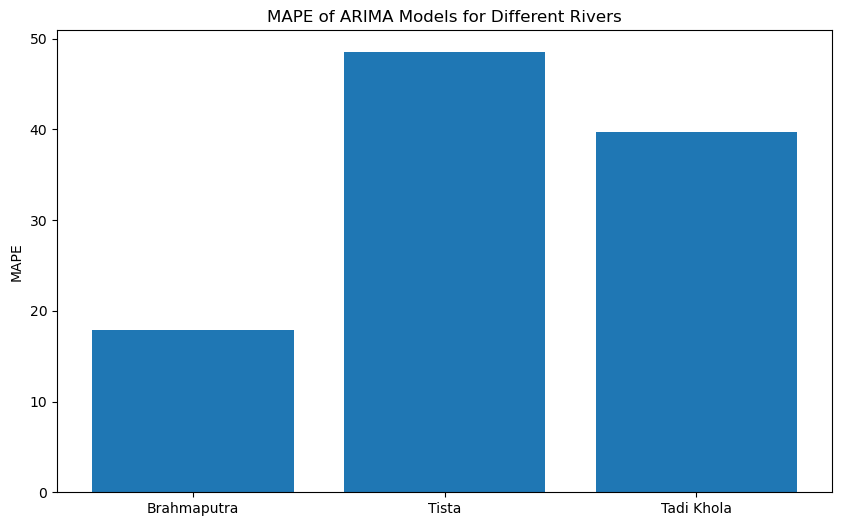

In [ ]:
# plot the results
plt.figure(figsize=(10,6))
plt.bar(results.keys(), [result['MAPE'] for result in results.values()])
plt.title('MAPE of ARIMA Models for Different Rivers')
plt.ylabel('MAPE')
plt.show()
